# Example: Estimating parameters of an anharmonic oscillator

The anharnomic oscillator can be modelled by a non-linear partial differential
equation as described in section 6.4.3 of the book Fundamentals of Algorithms
and Data Assimilation by Mark Asch, Marc Bocquet and Maëlle Nodet.

In [1]:
# Simple plotting of forward-model with a single response and parameters
from matplotlib import pyplot as plt


def plot_result(A, response_x_axis, trans_func=lambda x: x, priors=[]):
    responses = forward_model(A, priors, response_x_axis)
    plt.rcParams["figure.figsize"] = [15, 4]
    _, axs = plt.subplots(1, 1 + len(A))

    axs[0].plot(response_x_axis, responses)
    for i, param in enumerate(A):
        A_trans = np.array([trans_func(v, *priors[i]) for v in param])
        axs[i + 1].hist(A_trans, bins=10)
    plt.show()

## Setup

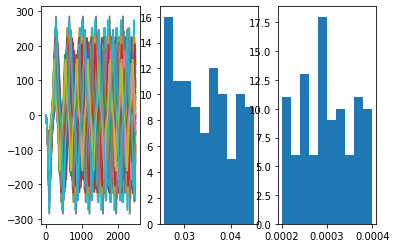

In [2]:
# Oscilator example
import numpy as np
from math import sqrt
from scipy.special import erf


def _generate_observations(K):

    x = _evaluate(omega=3.5e-2, lmbda=3e-4, K=K)
    rng = np.random.default_rng(12345)
    nobs = 50
    obs_points = np.linspace(0, K, nobs, endpoint=False, dtype=int)

    obs_with_std = np.zeros(shape=(len(obs_points), 2))

    for obs_idx, obs_point in enumerate(obs_points):
        # Set observation error's standard deviation to some
        # percentage of the amplitude of x with a minimum of, e.g., 1.
        obs_std = max(1, 0.02 * abs(x[obs_point]))
        obs_with_std[obs_idx, 0] = x[obs_point] + rng.normal(loc=0.0, scale=obs_std)
        obs_with_std[obs_idx, 1] = obs_std
    return obs_with_std, obs_points


def _evaluate(omega, lmbda, K):
    x = np.zeros(K)
    x[0] = 0
    x[1] = 1

    # Looping from 2 because we have initial conditions at k=0 and k=1.
    for k in range(2, K - 1):
        M = np.array([[2 + omega**2 - lmbda**2 * x[k] ** 2, -1], [1, 0]])
        u = np.array([x[k], x[k - 1]])
        u = M @ u
        x[k + 1] = u[0]
        x[k] = u[1]

    return x


def uniform(x, min_x, max_x):
    y = 0.5 * (1 + erf(x / sqrt(2.0)))
    return y * (max_x - min_x) + min_x


def forward_model(A, prior, response_x_axis):
    responses = []
    for [omega, lmbda] in A.T:
        r = _evaluate(
            omega=uniform(omega, *prior[0]),
            lmbda=uniform(lmbda, *prior[1]),
            K=len(response_x_axis),
        )
        responses.append(r)
    return np.array(responses).T


response_x_axis = range(2500)
realizations = 100

observations, observation_x_axis = _generate_observations(len(response_x_axis))
observation_values = observations[:, 0]
observation_errors = observations[:, 1]

A = np.random.normal(0, 1, size=(2, realizations))

priors = [(2.5e-2, 4.5e-2), (2.0e-4, 4.0e-4)]
plot_result(A, response_x_axis, uniform, priors)

## Update step

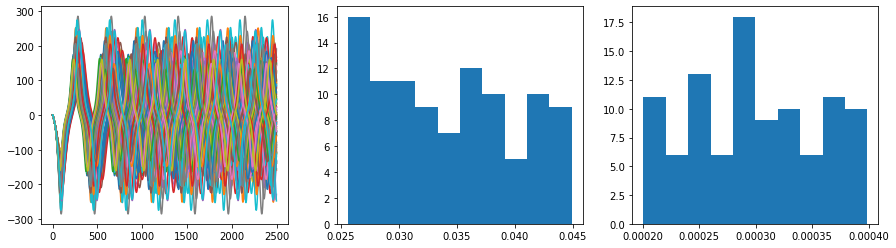

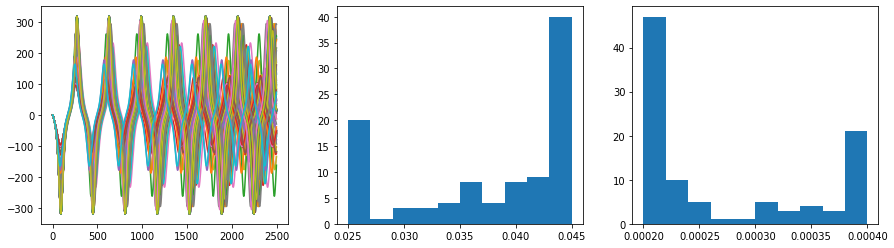

In [3]:
import numpy as np
import iterative_ensemble_smoother as ies

plot_result(A, response_x_axis, uniform, priors)

responses_before = forward_model(A, priors, response_x_axis)
S = responses_before[observation_x_axis]

new_A = ies.ensemble_smoother_update_step(S, A, observation_errors, observation_values)

plot_result(new_A, response_x_axis, uniform, priors)

## Iterative smoother

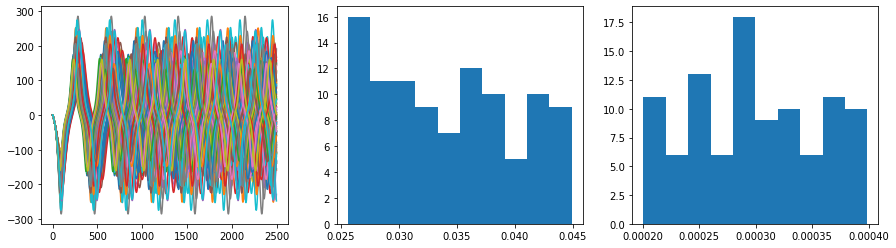

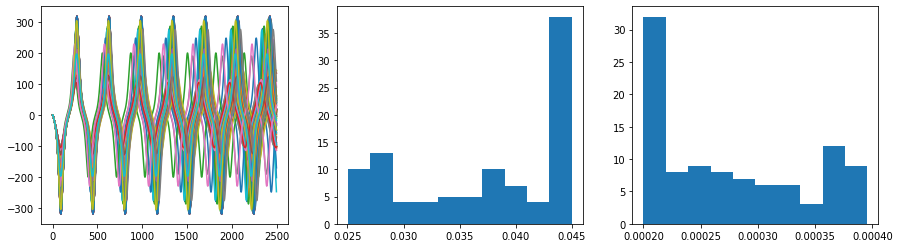

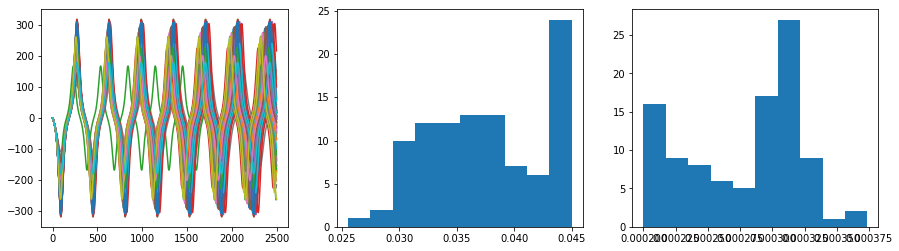

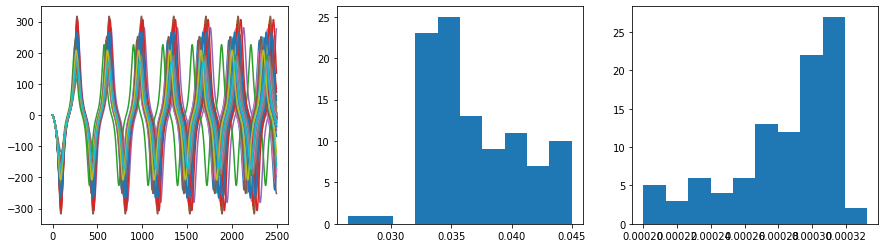

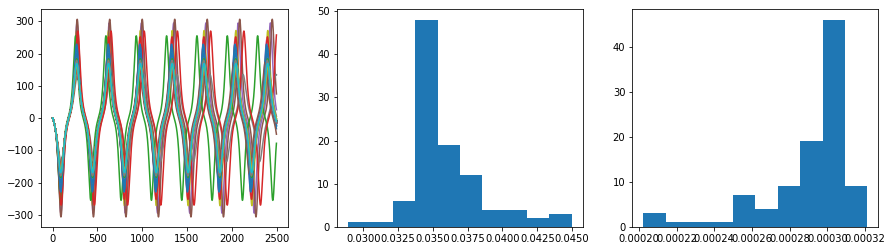

In [4]:
import numpy as np
from matplotlib import pyplot as plt
import iterative_ensemble_smoother as ies


def iterative_smoother():
    A_current = np.copy(A)
    iterations = 4
    smoother = ies.IterativeEnsembleSmoother(realizations)

    for _ in range(iterations):
        plot_result(A_current, response_x_axis, uniform, priors)

        responses_before = forward_model(A_current, priors, response_x_axis)
        S = responses_before[observation_x_axis]

        A_current = smoother.update_step(
            S, A_current, observation_errors, observation_values
        )
    plot_result(A_current, response_x_axis, uniform, priors)


iterative_smoother()

## ES-MDA (Multiple Data Assimilation - Ensemble Smoother)

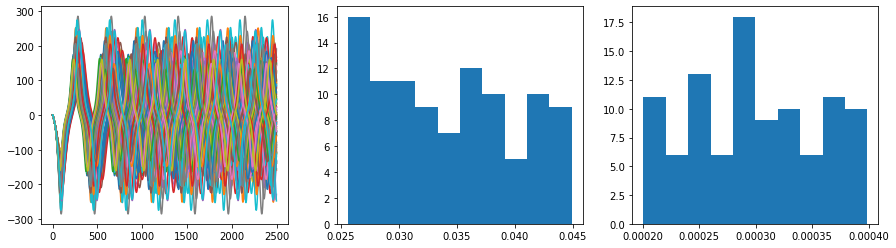

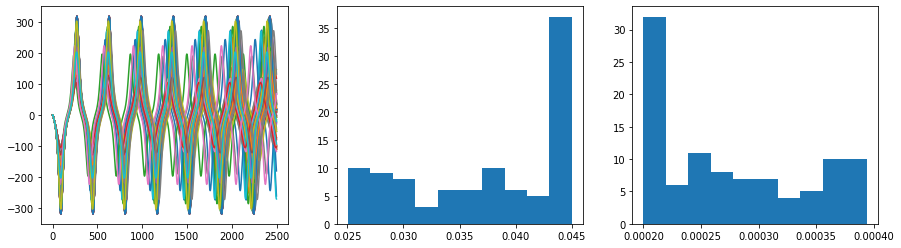

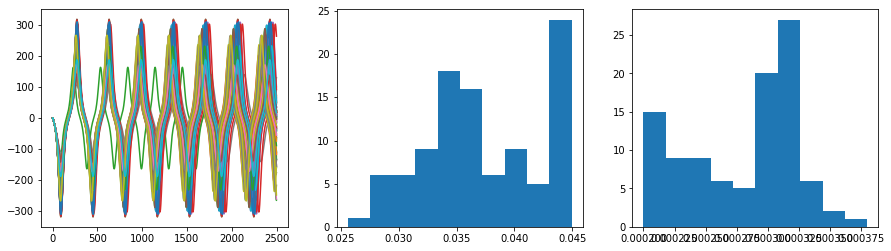

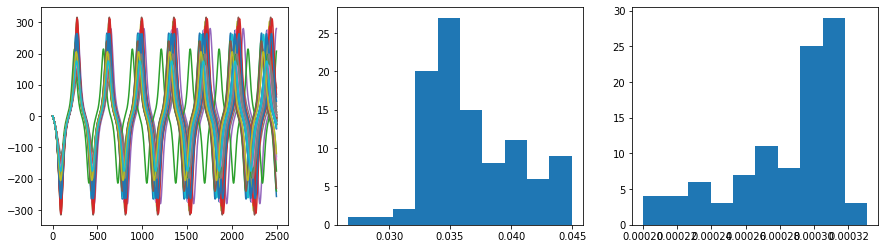

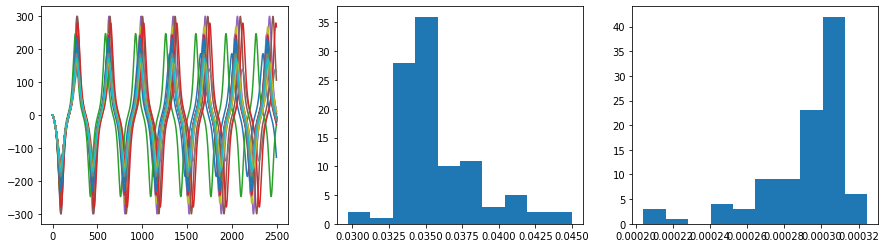

In [5]:
import numpy as np
from matplotlib import pyplot as plt
import iterative_ensemble_smoother as ies


def es_mda():
    A_current = np.copy(A)
    weights = [8, 4, 2, 1]
    length = sum(1.0 / x for x in weights)
    smoother = ies.IterativeEnsembleSmoother(realizations)

    for weight in weights:
        plot_result(A_current, response_x_axis, uniform, priors)

        responses_before = forward_model(A_current, priors, response_x_axis)
        S = responses_before[observation_x_axis]

        observation_errors_scaled = observation_errors*sqrt(weight*length)
        A_current = smoother.update_step(
            S, A_current, observation_errors_scaled, observation_values
        )
    plot_result(A_current, response_x_axis, uniform, priors)


es_mda()